In [ ]:
#In May 2025, torch_geometric is not installed On Colab, might change in the future.
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/MyDrive/ColabNotebooks/STAT_461")

Mounted at /content/drive


In [ ]:
!ls

base  EuclidNet_So2.ipynb  EuclidNet_VN_So2.ipynb  Files
data  EuclidNet_So3.ipynb  EuclidNet_VN_So3.ipynb  VN


In [ ]:
import os, gc, joblib, math, pandas as pd, numpy as np
from glob import glob
from tqdm.auto import tqdm, trange
from typing import Union, List
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor
import torch.optim as optim
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from scipy.optimize import root_scalar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
pd.set_option("display.max_columns", 100)

# project-specific paths
PATH_DATA0 = "./data/00.01"   # graphs_train/val/test.pkl live here
PATH_DATA  = "./data/00.03"   # where we save models + stats
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Using device: cuda


In [ ]:
CRITERION     = nn.BCELoss()
LR            = 1e-3
TOLERANCE     = 20
LR_TOLERANCE  = 5
MAX_EPOCHS    = 100
BATCH_SIZE    = 2

In [ ]:
loader_train = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_train.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = True)
loader_val = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = False)
loader_test = pyg.loader.DataLoader(
    pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl')).tolist(),
    batch_size = BATCH_SIZE,shuffle = False)

# Util Functions

In [ ]:
#Adapted from https://github.com/athete/equivariant-tracking
def norm(x: Tensor) -> Tensor:
    r"""Euclidean square norm
    `\|x\|^2 = x[0]^2+x[1]^2+x[2]^2`
    """
    x_sq = torch.pow(x, 2)
    return x_sq.sum(dim=-1)


def dot(x: Tensor, y: Tensor) -> Tensor:
    r"""Euclidean inner product
    `<x,y> = x[0]y[0]+x[1]y[1]+x[2]y[2]`
    """
    xy = x * y
    return xy.sum(dim=-1)


def psi(x: Tensor) -> Tensor:
    """`\psi(x) = sgn(x) \cdot \log(|x| + 1)`"""
    return torch.sign(x) * torch.log(torch.abs(x) + 1)

def euclidean_feats(
    edge_index: Tensor, x: Tensor, s: Union[Tensor, None]
) -> List[Tensor]:
    i, j = edge_index
    x_diff = x[i] - x[j]
    norms = norm(x_diff).unsqueeze(1)
    dots = dot(x[i], x[j]).unsqueeze(1)
    norms, dots = psi(norms), psi(dots)

    # Handle first GNN iteration
    s_cat = torch.cat([s[i], s[j]], dim=1) if s is not None else None

    return norms, dots, x_diff, s_cat

def unsorted_segment_mean(
    data: Tensor, segment_ids: Tensor, num_segments: int
) -> Tensor:
    r"""Custom PyTorch op to replicate TensorFlow's `unsorted_segment_mean`.
    Adapted from https://github.com/vgsatorras/egnn.
    """
    result = data.new_zeros((num_segments, data.size(1)))
    count = data.new_zeros((num_segments, data.size(1)))
    result.index_add_(0, segment_ids, data)
    count.index_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)

# Model Architecture

In [ ]:
#Adapted on top of baseline So(3) EuclidNet from https://github.com/athete/equivariant-tracking
#Add naive implementation of Virtual Node with inspration from https://arxiv.org/abs/2404.07194
class VirtualEB(nn.Module):
    def __init__(self, n_hidden: int = 32, c_weight: float = 1.0, use_virtual_node: bool = True) -> None:
        super(VirtualEB, self).__init__()
        # dims for norm & inner product
        self.n_edge_attributes = 2
        self.c_weight = c_weight
        self.use_virtual_node = use_virtual_node

        # MLP to create the message for real edges
        self.phi_e = nn.Sequential(
            nn.Linear(self.n_edge_attributes, n_hidden, bias=False),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
        )

        # MLP for virtual node messages (no geometric features)
        if self.use_virtual_node:
            self.phi_v = nn.Sequential(
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
            )

        layer = nn.Linear(n_hidden, 1, bias=False)
        nn.init.xavier_uniform_(layer.weight, gain=0.001)
        # MLP to generate attention weights
        self.phi_x = nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.ReLU(), layer)

        # MLP to generate weights for the messages
        self.phi_m = nn.Sequential(nn.Linear(n_hidden, 1), nn.Sigmoid())

        # Virtual node update MLP
        if self.use_virtual_node:
            self.virtual_update = nn.Sequential(
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden)
            )

    def message(self, norms, dots, virtual_features=None):
        m_ij = torch.cat([norms, dots], dim=1)
        m_ij = self.phi_e(m_ij)
        w = self.phi_m(m_ij)
        m_ij = m_ij * w
        return m_ij

    def virtual_message(self, virtual_node, real_nodes):
        if not self.use_virtual_node:
            return None, None

        batch_size = real_nodes.size(0)
        # Broadcast virtual node to all real nodes
        virtual_expanded = virtual_node.expand(batch_size, -1)

        # Message from virtual to real nodes
        v_to_real = self.phi_v(virtual_expanded)

        # Message from real nodes to virtual (aggregated)
        real_to_v = torch.mean(real_nodes, dim=0, keepdim=True)

        return v_to_real, real_to_v

    def x_model(self, x, edge_index, x_diff, m, virtual_msg=None):
        i, j = edge_index
        update_val = x_diff * self.phi_x(m)

        # Add virtual node contribution if available
        if virtual_msg is not None and self.use_virtual_node:
            # Virtual node doesn't contribute to position updates directly
            # but influences through the message passing
            pass

        # LorentzNet authors clamp the update tensor as a precautionary measure
        update_val = torch.clamp(update_val, min=-100, max=100)
        x_agg = unsorted_segment_mean(update_val, i, num_segments=x.size(0))
        x = x + x_agg * self.c_weight
        return x

    def update_virtual_node(self, virtual_node, real_to_virtual_msg):
        if not self.use_virtual_node:
            return virtual_node

        updated_virtual = self.virtual_update(real_to_virtual_msg)
        return virtual_node + updated_virtual

    def forward(self, x, edge_index, virtual_node=None, node_features=None):
        norms, dots, x_diff, _ = euclidean_feats(edge_index, x, None)
        m = self.message(norms, dots)

        # Handle virtual node interactions
        virtual_to_real_msg = None
        if self.use_virtual_node and virtual_node is not None and node_features is not None:
            virtual_to_real_msg, real_to_virtual_msg = self.virtual_message(virtual_node, node_features)
            # Update virtual node
            virtual_node = self.update_virtual_node(virtual_node, real_to_virtual_msg)

        # Update real node positions
        x_tilde = self.x_model(x, edge_index, x_diff, m, virtual_to_real_msg)

        # Incorporate virtual node information into node features if available
        if virtual_to_real_msg is not None:
          node_features += virtual_to_real_msg

        return x_tilde, m, virtual_node


class VirtualEuclidNet(nn.Module):
    def __init__(self, hparams) -> None:
        super(VirtualEuclidNet, self).__init__()

        self.hparams = hparams
        self.n_input = hparams["n_input"]
        self.n_output = hparams["n_output"]
        self.n_hidden = hparams["n_hidden"]
        self.n_layers = hparams["n_layers"]
        self.c_weight = hparams["c_weight"]
        self.use_virtual_node = hparams.get("use_virtual_node", True)

        # Initialize virtual node features
        if self.use_virtual_node:
            self.virtual_node_init = nn.Parameter(torch.randn(1, self.n_hidden))
            nn.init.xavier_uniform_(self.virtual_node_init)

        self.EBs = nn.ModuleList(
            [
                VirtualEB(
                    n_hidden=self.n_hidden,
                    c_weight=self.c_weight,
                    use_virtual_node=self.use_virtual_node
                )
                for _ in range(self.n_layers)
            ]
        )

        # Node feature embedding (if not provided)
        self.node_embedding = nn.Linear(self.n_input, self.n_hidden)

        # Enhanced edge MLP that can incorporate virtual node information
        edge_mlp_input_dim = 2 * self.n_input + self.n_hidden
        if self.use_virtual_node:
            edge_mlp_input_dim += self.n_hidden  # Add virtual node features
        layers = [nn.Linear(edge_mlp_input_dim, self.n_hidden),
            nn.ReLU()]

        # Change of hidden layers
        if n_layers>=2:
          for _ in range(n_layers - 1):
              layers.append(nn.Linear(self.n_hidden, self.n_hidden))
              layers.append(nn.ReLU())
        layers.append(nn.Linear(self.n_hidden, self.n_output))
        self.edge_mlp = nn.Sequential(*layers)


    def forward(self, x, edge_index, node_features=None):
        batch_size = x.size(0)

        # Initialize or use provided node features
        if node_features is None:
            # Create simple node features from positions
            node_features = self.node_embedding(x)

        # Initialize virtual node
        virtual_node = None
        if self.use_virtual_node:
            virtual_node = self.virtual_node_init.clone()

        # Forward through layers
        for i in range(self.n_layers):
            x, m_ij, virtual_node = self.EBs[i](x, edge_index, virtual_node, node_features)

        # Prepare edge features for final prediction
        edge_features = [x[edge_index[1]], x[edge_index[0]], m_ij]

        # Add virtual node information to edge prediction
        if self.use_virtual_node and virtual_node is not None:
            # Broadcast virtual node features to all edges
            n_edges = edge_index.size(1)
            virtual_expanded = virtual_node.expand(n_edges, -1)
            edge_features.append(virtual_expanded)

        m = torch.cat(edge_features, dim=1)
        return torch.sigmoid(self.edge_mlp(m))

# Helper Functions

In [ ]:
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

def evaluate(model, loader):
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index)
            preds.append(output)
            actuals.append(batch.y)
        preds = torch.cat(preds)
        actuals = torch.cat(actuals)
        acc = ((preds > 0.5) == (actuals > 0.5)).type(torch.float).mean().item()
        entropy = CRITERION(preds, actuals.float()).item()
    model.train()
    return preds.cpu().numpy(), actuals.cpu().numpy(), acc, entropy

def train_epoch(model, loader_train, optimizer):
    model.train()
    train_loss = 0.0
    for batch in tqdm(loader_train, leave=False):
        batch = batch.to(device)
        optimizer.zero_grad()
        # EuclidNet only need x & edge_index
        output = model(batch.x, batch.edge_index)
        loss = CRITERION(output, batch.y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(loader_train)
    return train_loss

# Training Loop Function

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Training n_layers=4, target_params=100000
Actual amount of parameter: 101273
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.8110 |    0.3452 |   0.8494 |    0.8533 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.6288 |    0.3017 |   0.8595 |    0.8630 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.5961 |    0.2950 |   0.8609 |    0.8647 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5786 |    0.2872 |   0.8634 |    0.8670 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5608 |    0.2835 |   0.8670 |    0.8707 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5492 |    0.2723 |   0.8696 |    0.8734 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5427 |    0.2703 |   0.8701 |    0.8738 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.5359 |    0.2700 |   0.8698 |    0.8735 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.5334 |    0.2664 |   0.8719 |    0.8755 *


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.5295 |    0.2646 |   0.8725 |    0.8759 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.5249 |    0.2751 |   0.8683 |    0.8714


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.5240 |    0.2637 |   0.8725 |    0.8760 *


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.5228 |    0.2704 |   0.8686 |    0.8716


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.5208 |    0.2615 |   0.8741 |    0.8775 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.5189 |    0.2604 |   0.8746 |    0.8781 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.5168 |    0.2636 |   0.8736 |    0.8773


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.5164 |    0.2616 |   0.8745 |    0.8780


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.5149 |    0.2592 |   0.8752 |    0.8787 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.5141 |    0.2615 |   0.8741 |    0.8776


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.5139 |    0.2584 |   0.8755 |    0.8787 *


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.5128 |    0.2570 |   0.8756 |    0.8789 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.5137 |    0.2612 |   0.8738 |    0.8768


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.5100 |    0.2592 |   0.8754 |    0.8790


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.5108 |    0.2566 |   0.8759 |    0.8790 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.5100 |    0.2577 |   0.8754 |    0.8785


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.5109 |    0.2554 |   0.8760 |    0.8792 *


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.5094 |    0.2567 |   0.8763 |    0.8796


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.5103 |    0.2623 |   0.8751 |    0.8786


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.5089 |    0.2622 |   0.8740 |    0.8769


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.5079 |    0.2546 |   0.8768 |    0.8799 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.5077 |    0.2553 |   0.8769 |    0.8802


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.5057 |    0.2612 |   0.8751 |    0.8786


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.5059 |    0.2547 |   0.8763 |    0.8795


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.5063 |    0.2566 |   0.8764 |    0.8799


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.5055 |    0.2529 |   0.8773 |    0.8804 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.5047 |    0.2552 |   0.8763 |    0.8798


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.5055 |    0.2555 |   0.8769 |    0.8803


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.5043 |    0.2526 |   0.8773 |    0.8804 *


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.5051 |    0.2523 |   0.8776 |    0.8807 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.5047 |    0.2537 |   0.8769 |    0.8799


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.5034 |    0.2525 |   0.8779 |    0.8810


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.5036 |    0.2542 |   0.8764 |    0.8795


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.5036 |    0.2528 |   0.8772 |    0.8802


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.5047 |    0.2525 |   0.8766 |    0.8798
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.4980 |    0.2508 |   0.8781 |    0.8813 *


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.4973 |    0.2506 |   0.8781 |    0.8813 *


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.4975 |    0.2513 |   0.8779 |    0.8813


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.4970 |    0.2505 |   0.8783 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.4976 |    0.2505 |   0.8783 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.4972 |    0.2506 |   0.8782 |    0.8814


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.4969 |    0.2507 |   0.8783 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.4970 |    0.2507 |   0.8781 |    0.8813


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.4971 |    0.2508 |   0.8784 |    0.8815
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.4961 |    0.2501 |   0.8783 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.4958 |    0.2504 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.4961 |    0.2501 |   0.8784 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.4962 |    0.2501 |   0.8783 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.4962 |    0.2501 |   0.8783 |    0.8814


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4959 |    0.2501 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.4964 |    0.2500 |   0.8783 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4961 |    0.2506 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.4959 |    0.2502 |   0.8783 |    0.8814


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4964 |    0.2501 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.4961 |    0.2500 |   0.8784 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4961 |    0.2502 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.4963 |    0.2501 |   0.8783 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4958 |    0.2500 |   0.8784 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4957 |    0.2501 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4962 |    0.2501 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4961 |    0.2502 |   0.8783 |    0.8814


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4960 |    0.2501 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4963 |    0.2502 |   0.8784 |    0.8816
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4956 |    0.2500 |   0.8784 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4954 |    0.2500 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4960 |    0.2500 |   0.8784 |    0.8815 *


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4961 |    0.2501 |   0.8785 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4956 |    0.2500 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4961 |    0.2501 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4961 |    0.2501 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4958 |    0.2501 |   0.8784 |    0.8816
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.4954 |    0.2501 |   0.8785 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4961 |    0.2501 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4956 |    0.2499 |   0.8784 |    0.8816 *


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4958 |    0.2502 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4959 |    0.2500 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.4958 |    0.2501 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4956 |    0.2501 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.4959 |    0.2501 |   0.8784 |    0.8815
LR decreases to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.4960 |    0.2504 |   0.8781 |    0.8813


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.4957 |    0.2500 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.4954 |    0.2500 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.4959 |    0.2500 |   0.8783 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.4952 |    0.2503 |   0.8785 |    0.8816
LR decreases to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.4959 |    0.2500 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.4958 |    0.2502 |   0.8784 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.4958 |    0.2500 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.4953 |    0.2501 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.4956 |    0.2500 |   0.8784 |    0.8816


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.4953 |    0.2501 |   0.8783 |    0.8815


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.4959 |    0.2503 |   0.8785 |    0.8816


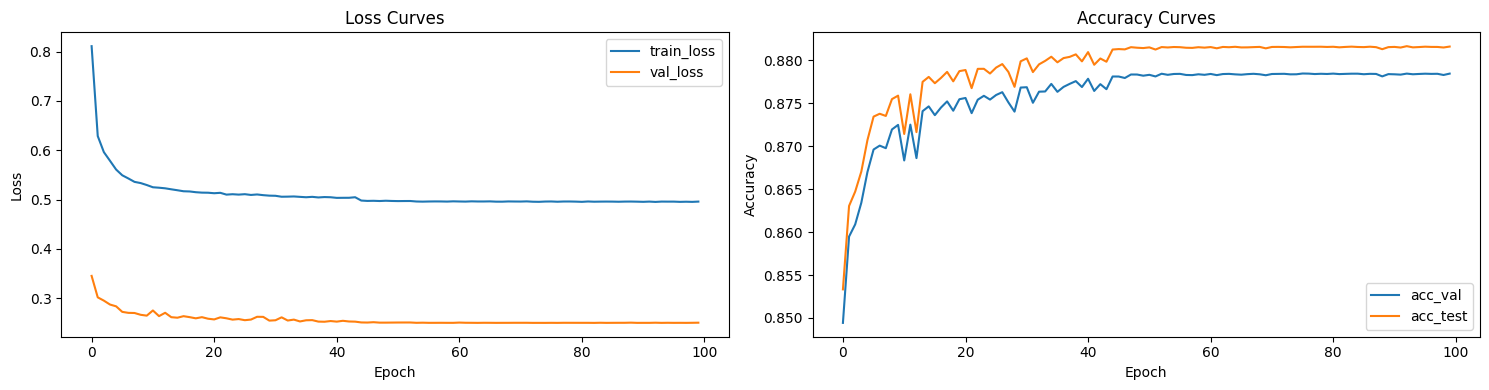

Training n_layers=4, target_params=500000
Actual amount of parameter: 498425
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.7142 |    0.3065 |   0.8584 |    0.8619 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.5980 |    0.2946 |   0.8609 |    0.8649 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.5702 |    0.2883 |   0.8626 |    0.8664 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5556 |    0.2781 |   0.8669 |    0.8704 *


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5450 |    0.2701 |   0.8706 |    0.8742 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5346 |    0.2690 |   0.8714 |    0.8753 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5298 |    0.2655 |   0.8723 |    0.8759 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.5253 |    0.2660 |   0.8724 |    0.8764


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.5220 |    0.2669 |   0.8732 |    0.8767


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.5206 |    0.2596 |   0.8759 |    0.8797 *


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.5162 |    0.2638 |   0.8736 |    0.8766


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.5142 |    0.2621 |   0.8741 |    0.8773


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.5139 |    0.2577 |   0.8770 |    0.8805 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.5119 |    0.2622 |   0.8746 |    0.8781


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.5099 |    0.2552 |   0.8775 |    0.8811 *


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.5088 |    0.2565 |   0.8772 |    0.8805


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.5099 |    0.2591 |   0.8751 |    0.8782


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.5082 |    0.2528 |   0.8789 |    0.8824 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.5053 |    0.2561 |   0.8769 |    0.8804


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.5053 |    0.2565 |   0.8758 |    0.8791


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.5049 |    0.2528 |   0.8787 |    0.8824 *


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.5024 |    0.2530 |   0.8791 |    0.8827


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.5025 |    0.2527 |   0.8786 |    0.8823 *


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.5009 |    0.2519 |   0.8784 |    0.8819 *


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.5021 |    0.2523 |   0.8791 |    0.8827


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.4999 |    0.2550 |   0.8777 |    0.8811


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.4999 |    0.2546 |   0.8779 |    0.8814


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.5009 |    0.2531 |   0.8784 |    0.8819


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.4988 |    0.2546 |   0.8783 |    0.8819
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.4906 |    0.2476 |   0.8807 |    0.8841 *


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.4895 |    0.2473 |   0.8808 |    0.8842 *


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.4889 |    0.2471 |   0.8808 |    0.8842 *


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.4891 |    0.2476 |   0.8808 |    0.8843


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.4893 |    0.2471 |   0.8808 |    0.8841 *


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.4884 |    0.2468 |   0.8809 |    0.8844 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.4888 |    0.2470 |   0.8810 |    0.8843


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.4883 |    0.2469 |   0.8811 |    0.8845


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.4885 |    0.2468 |   0.8808 |    0.8841


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.4884 |    0.2467 |   0.8810 |    0.8844 *


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.4879 |    0.2467 |   0.8810 |    0.8845 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.4885 |    0.2465 |   0.8812 |    0.8845 *


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.4874 |    0.2466 |   0.8811 |    0.8845


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.4876 |    0.2465 |   0.8812 |    0.8845 *


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.4877 |    0.2468 |   0.8809 |    0.8841


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.4877 |    0.2468 |   0.8813 |    0.8846


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.4873 |    0.2468 |   0.8810 |    0.8843


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.4872 |    0.2472 |   0.8812 |    0.8845


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.4873 |    0.2463 |   0.8813 |    0.8845 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.4872 |    0.2465 |   0.8812 |    0.8844


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.4869 |    0.2465 |   0.8813 |    0.8846


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.4872 |    0.2462 |   0.8813 |    0.8846 *


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.4866 |    0.2462 |   0.8812 |    0.8847 *


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.4875 |    0.2463 |   0.8812 |    0.8845


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.4864 |    0.2459 |   0.8813 |    0.8846 *


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.4872 |    0.2461 |   0.8812 |    0.8845


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.4863 |    0.2461 |   0.8814 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.4867 |    0.2465 |   0.8813 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.4867 |    0.2460 |   0.8814 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4862 |    0.2463 |   0.8815 |    0.8849
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.4857 |    0.2457 |   0.8815 |    0.8848 *


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4850 |    0.2457 |   0.8815 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.4850 |    0.2457 |   0.8816 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4852 |    0.2457 |   0.8815 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.4848 |    0.2457 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4854 |    0.2459 |   0.8815 |    0.8849
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.4850 |    0.2460 |   0.8815 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4844 |    0.2456 |   0.8815 |    0.8848 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4845 |    0.2458 |   0.8816 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4848 |    0.2462 |   0.8815 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4851 |    0.2456 |   0.8816 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4851 |    0.2460 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4848 |    0.2458 |   0.8815 |    0.8848
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4850 |    0.2457 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4844 |    0.2457 |   0.8816 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4848 |    0.2457 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4847 |    0.2457 |   0.8816 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4845 |    0.2457 |   0.8816 |    0.8849
LR decreases to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4850 |    0.2457 |   0.8816 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4850 |    0.2458 |   0.8815 |    0.8847


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4845 |    0.2457 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.4849 |    0.2457 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4848 |    0.2457 |   0.8815 |    0.8847
LR decreases to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4846 |    0.2460 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4854 |    0.2456 |   0.8816 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4848 |    0.2456 |   0.8815 |    0.8848


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.4847 |    0.2458 |   0.8816 |    0.8849


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4850 |    0.2458 |   0.8816 |    0.8848
Early stop at 87 round


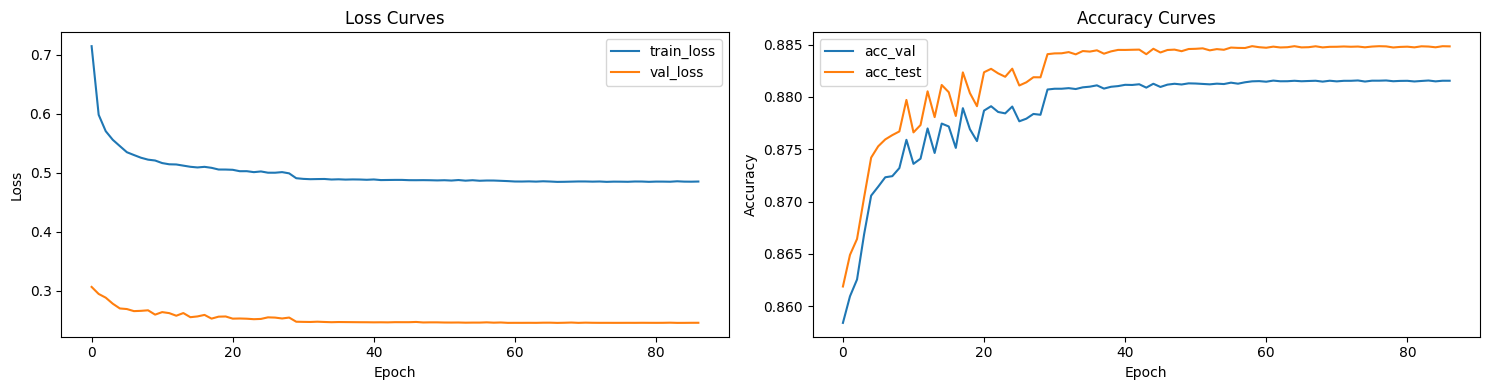

Training n_layers=4, target_params=1000000
Actual amount of parameter: 1004370
Epoch | Train Loss |  Val Loss |  Val Acc |  Test Acc
--------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/283 [00:00<?, ?it/s]

    1 |     0.6952 |    0.3101 |   0.8553 |    0.8589 *


  0%|          | 0/283 [00:00<?, ?it/s]

    2 |     0.5846 |    0.2830 |   0.8642 |    0.8680 *


  0%|          | 0/283 [00:00<?, ?it/s]

    3 |     0.5582 |    0.2754 |   0.8680 |    0.8717 *


  0%|          | 0/283 [00:00<?, ?it/s]

    4 |     0.5505 |    0.2765 |   0.8684 |    0.8721


  0%|          | 0/283 [00:00<?, ?it/s]

    5 |     0.5425 |    0.2713 |   0.8698 |    0.8736 *


  0%|          | 0/283 [00:00<?, ?it/s]

    6 |     0.5367 |    0.2692 |   0.8708 |    0.8747 *


  0%|          | 0/283 [00:00<?, ?it/s]

    7 |     0.5301 |    0.2669 |   0.8714 |    0.8754 *


  0%|          | 0/283 [00:00<?, ?it/s]

    8 |     0.5276 |    0.2625 |   0.8734 |    0.8770 *


  0%|          | 0/283 [00:00<?, ?it/s]

    9 |     0.5225 |    0.2638 |   0.8746 |    0.8781


  0%|          | 0/283 [00:00<?, ?it/s]

   10 |     0.5173 |    0.2673 |   0.8723 |    0.8762


  0%|          | 0/283 [00:00<?, ?it/s]

   11 |     0.5127 |    0.2583 |   0.8758 |    0.8794 *


  0%|          | 0/283 [00:00<?, ?it/s]

   12 |     0.5124 |    0.2614 |   0.8748 |    0.8785


  0%|          | 0/283 [00:00<?, ?it/s]

   13 |     0.5098 |    0.2572 |   0.8766 |    0.8802 *


  0%|          | 0/283 [00:00<?, ?it/s]

   14 |     0.5092 |    0.2545 |   0.8777 |    0.8812 *


  0%|          | 0/283 [00:00<?, ?it/s]

   15 |     0.5058 |    0.2550 |   0.8772 |    0.8805


  0%|          | 0/283 [00:00<?, ?it/s]

   16 |     0.5038 |    0.2540 |   0.8787 |    0.8822 *


  0%|          | 0/283 [00:00<?, ?it/s]

   17 |     0.5032 |    0.2534 |   0.8783 |    0.8818 *


  0%|          | 0/283 [00:00<?, ?it/s]

   18 |     0.5013 |    0.2520 |   0.8787 |    0.8820 *


  0%|          | 0/283 [00:00<?, ?it/s]

   19 |     0.5015 |    0.2527 |   0.8794 |    0.8826


  0%|          | 0/283 [00:00<?, ?it/s]

   20 |     0.5004 |    0.2529 |   0.8790 |    0.8822


  0%|          | 0/283 [00:00<?, ?it/s]

   21 |     0.4988 |    0.2523 |   0.8794 |    0.8829


  0%|          | 0/283 [00:00<?, ?it/s]

   22 |     0.4966 |    0.2504 |   0.8794 |    0.8827 *


  0%|          | 0/283 [00:00<?, ?it/s]

   23 |     0.4975 |    0.2502 |   0.8800 |    0.8832 *


  0%|          | 0/283 [00:00<?, ?it/s]

   24 |     0.4970 |    0.2524 |   0.8794 |    0.8829


  0%|          | 0/283 [00:00<?, ?it/s]

   25 |     0.4952 |    0.2549 |   0.8790 |    0.8823


  0%|          | 0/283 [00:00<?, ?it/s]

   26 |     0.4970 |    0.2502 |   0.8803 |    0.8835


  0%|          | 0/283 [00:00<?, ?it/s]

   27 |     0.4940 |    0.2509 |   0.8805 |    0.8836


  0%|          | 0/283 [00:00<?, ?it/s]

   28 |     0.4939 |    0.2481 |   0.8806 |    0.8840 *


  0%|          | 0/283 [00:00<?, ?it/s]

   29 |     0.4924 |    0.2520 |   0.8802 |    0.8836


  0%|          | 0/283 [00:00<?, ?it/s]

   30 |     0.4929 |    0.2490 |   0.8810 |    0.8843


  0%|          | 0/283 [00:00<?, ?it/s]

   31 |     0.4928 |    0.2498 |   0.8798 |    0.8831


  0%|          | 0/283 [00:00<?, ?it/s]

   32 |     0.4919 |    0.2513 |   0.8800 |    0.8834


  0%|          | 0/283 [00:00<?, ?it/s]

   33 |     0.4911 |    0.2498 |   0.8807 |    0.8841
LR decreases to 0.0001


  0%|          | 0/283 [00:00<?, ?it/s]

   34 |     0.4819 |    0.2447 |   0.8822 |    0.8855 *


  0%|          | 0/283 [00:00<?, ?it/s]

   35 |     0.4817 |    0.2443 |   0.8825 |    0.8857 *


  0%|          | 0/283 [00:00<?, ?it/s]

   36 |     0.4804 |    0.2439 |   0.8825 |    0.8855 *


  0%|          | 0/283 [00:00<?, ?it/s]

   37 |     0.4809 |    0.2442 |   0.8825 |    0.8854


  0%|          | 0/283 [00:00<?, ?it/s]

   38 |     0.4801 |    0.2441 |   0.8827 |    0.8857


  0%|          | 0/283 [00:00<?, ?it/s]

   39 |     0.4801 |    0.2440 |   0.8826 |    0.8856


  0%|          | 0/283 [00:00<?, ?it/s]

   40 |     0.4799 |    0.2437 |   0.8828 |    0.8857 *


  0%|          | 0/283 [00:00<?, ?it/s]

   41 |     0.4801 |    0.2440 |   0.8826 |    0.8857


  0%|          | 0/283 [00:00<?, ?it/s]

   42 |     0.4801 |    0.2437 |   0.8827 |    0.8857


  0%|          | 0/283 [00:00<?, ?it/s]

   43 |     0.4796 |    0.2438 |   0.8827 |    0.8856


  0%|          | 0/283 [00:00<?, ?it/s]

   44 |     0.4802 |    0.2436 |   0.8828 |    0.8857 *


  0%|          | 0/283 [00:00<?, ?it/s]

   45 |     0.4794 |    0.2438 |   0.8827 |    0.8856


  0%|          | 0/283 [00:00<?, ?it/s]

   46 |     0.4795 |    0.2438 |   0.8829 |    0.8858


  0%|          | 0/283 [00:00<?, ?it/s]

   47 |     0.4794 |    0.2436 |   0.8829 |    0.8858 *


  0%|          | 0/283 [00:00<?, ?it/s]

   48 |     0.4793 |    0.2436 |   0.8829 |    0.8859 *


  0%|          | 0/283 [00:00<?, ?it/s]

   49 |     0.4789 |    0.2439 |   0.8825 |    0.8854


  0%|          | 0/283 [00:00<?, ?it/s]

   50 |     0.4797 |    0.2434 |   0.8828 |    0.8859 *


  0%|          | 0/283 [00:00<?, ?it/s]

   51 |     0.4791 |    0.2437 |   0.8826 |    0.8856


  0%|          | 0/283 [00:00<?, ?it/s]

   52 |     0.4788 |    0.2434 |   0.8829 |    0.8859


  0%|          | 0/283 [00:00<?, ?it/s]

   53 |     0.4792 |    0.2434 |   0.8827 |    0.8858


  0%|          | 0/283 [00:00<?, ?it/s]

   54 |     0.4787 |    0.2435 |   0.8828 |    0.8857


  0%|          | 0/283 [00:00<?, ?it/s]

   55 |     0.4785 |    0.2435 |   0.8829 |    0.8859
LR decreases to 1e-05


  0%|          | 0/283 [00:00<?, ?it/s]

   56 |     0.4770 |    0.2433 |   0.8829 |    0.8859 *


  0%|          | 0/283 [00:00<?, ?it/s]

   57 |     0.4770 |    0.2431 |   0.8830 |    0.8860 *


  0%|          | 0/283 [00:00<?, ?it/s]

   58 |     0.4767 |    0.2430 |   0.8829 |    0.8860 *


  0%|          | 0/283 [00:00<?, ?it/s]

   59 |     0.4770 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   60 |     0.4768 |    0.2433 |   0.8830 |    0.8859


  0%|          | 0/283 [00:00<?, ?it/s]

   61 |     0.4776 |    0.2433 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   62 |     0.4773 |    0.2432 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   63 |     0.4772 |    0.2433 |   0.8830 |    0.8860
LR decreases to 1.0000000000000002e-06


  0%|          | 0/283 [00:00<?, ?it/s]

   64 |     0.4768 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   65 |     0.4765 |    0.2434 |   0.8829 |    0.8859


  0%|          | 0/283 [00:00<?, ?it/s]

   66 |     0.4767 |    0.2430 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   67 |     0.4766 |    0.2430 |   0.8830 |    0.8860 *


  0%|          | 0/283 [00:00<?, ?it/s]

   68 |     0.4769 |    0.2430 |   0.8829 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   69 |     0.4771 |    0.2432 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   70 |     0.4769 |    0.2430 |   0.8829 |    0.8860 *


  0%|          | 0/283 [00:00<?, ?it/s]

   71 |     0.4766 |    0.2432 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   72 |     0.4767 |    0.2431 |   0.8829 |    0.8859


  0%|          | 0/283 [00:00<?, ?it/s]

   73 |     0.4766 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   74 |     0.4766 |    0.2430 |   0.8830 |    0.8859


  0%|          | 0/283 [00:00<?, ?it/s]

   75 |     0.4764 |    0.2433 |   0.8829 |    0.8858
LR decreases to 1.0000000000000002e-07


  0%|          | 0/283 [00:00<?, ?it/s]

   76 |     0.4769 |    0.2432 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   77 |     0.4766 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   78 |     0.4767 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   79 |     0.4768 |    0.2432 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   80 |     0.4761 |    0.2430 |   0.8830 |    0.8860 *


  0%|          | 0/283 [00:00<?, ?it/s]

   81 |     0.4770 |    0.2432 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   82 |     0.4764 |    0.2430 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   83 |     0.4768 |    0.2430 |   0.8830 |    0.8860 *


  0%|          | 0/283 [00:00<?, ?it/s]

   84 |     0.4765 |    0.2432 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   85 |     0.4768 |    0.2430 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   86 |     0.4766 |    0.2430 |   0.8830 |    0.8859


  0%|          | 0/283 [00:00<?, ?it/s]

   87 |     0.4765 |    0.2430 |   0.8829 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   88 |     0.4770 |    0.2431 |   0.8831 |    0.8860
LR decreases to 1.0000000000000002e-08


  0%|          | 0/283 [00:00<?, ?it/s]

   89 |     0.4767 |    0.2432 |   0.8830 |    0.8859


  0%|          | 0/283 [00:00<?, ?it/s]

   90 |     0.4767 |    0.2432 |   0.8829 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   91 |     0.4770 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   92 |     0.4772 |    0.2430 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   93 |     0.4769 |    0.2430 |   0.8830 |    0.8860
LR decreases to 1.0000000000000003e-09


  0%|          | 0/283 [00:00<?, ?it/s]

   94 |     0.4768 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   95 |     0.4768 |    0.2430 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   96 |     0.4768 |    0.2433 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   97 |     0.4771 |    0.2431 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   98 |     0.4765 |    0.2430 |   0.8830 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

   99 |     0.4766 |    0.2432 |   0.8829 |    0.8860


  0%|          | 0/283 [00:00<?, ?it/s]

  100 |     0.4768 |    0.2431 |   0.8830 |    0.8859


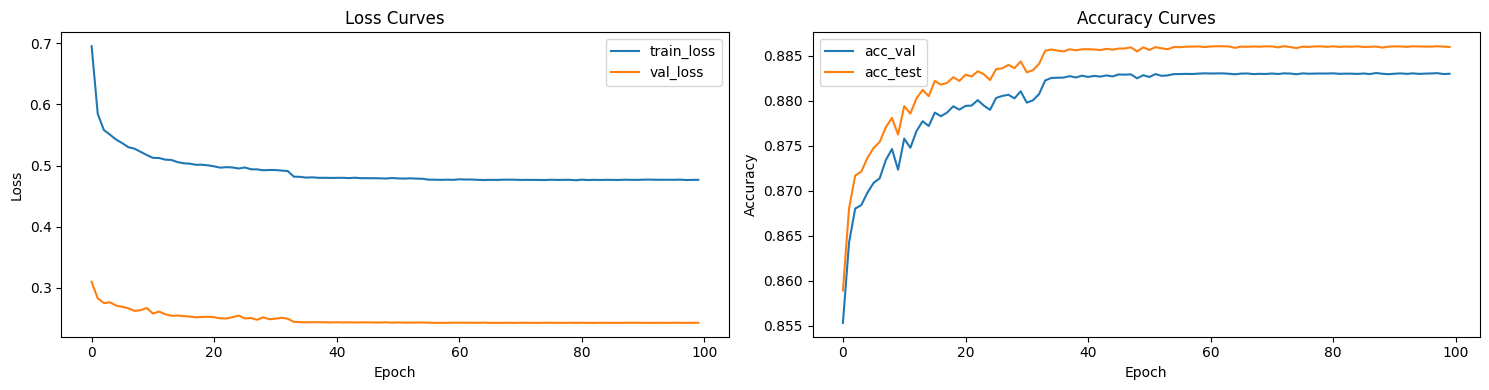

In [ ]:
def train_euclidnet(n_layers, target_params):
    gc.collect()
    torch.cuda.empty_cache()
    print(f"Training n_layers={n_layers}, target_params={target_params}")

    def objective(h):
        hparams = {
            "n_input": 3,      # 3D Coordniates
            "n_output": 1,     # edge classification result
            "n_hidden": int(h),
            "n_layers": n_layers,
            "c_weight": 1.0
        }
        return count_parameters(VirtualEuclidNet(hparams)) - target_params

    optimal_h = int(root_scalar(objective, bracket=[1, 1000], method='bisect').root)

    # Find hidden_size that suit #parameter
    candidates = {optimal_h-1, optimal_h, optimal_h+1}
    best_h = min(candidates, key=lambda h: abs(objective(h)) if h > 0 else float('inf'))

    hparams = {
        "n_input": 3,
        "n_output": 1,
        "n_hidden": best_h,
        "n_layers": n_layers,
        "c_weight": 1.0
    }

    model = VirtualEuclidNet(hparams).to(device)
    print(f"Actual amount of parameter: {count_parameters(model)}")

    lr = LR
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    epochs_no_improve, epochs_no_improve2 = 0, 0
    stats = []
    best = None

    print(f"{'Epoch':>5} | {'Train Loss':>10} | {'Val Loss':>9} | {'Val Acc':>8} | {'Test Acc':>9}")
    print("-" * 50)

    for epoch in trange(MAX_EPOCHS):
        train_loss = train_epoch(model, loader_train, optimizer)
        preds_val, actuals_val, acc_val, val_loss = evaluate(model, loader_val)
        preds_test, actuals_test, acc_test, test_loss = evaluate(model, loader_test)

        stats.append({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'acc_val': acc_val,
            'acc_test': acc_test
        })

        if val_loss < best_val_loss:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f} *")
            best_val_loss = val_loss
            epochs_no_improve = 0
            epochs_no_improve2 = 0
            best = {
                'model_state': {k: v.cpu() for k, v in model.state_dict().items()},
                'preds_test': preds_test,
                'preds_val': preds_val,
                'hparams': hparams
            }
        else:
            print(f"{epoch+1:5d} | {train_loss:10.4f} | {val_loss:9.4f} | {acc_val:8.4f} | {acc_test:9.4f}")
            epochs_no_improve += 1
            epochs_no_improve2 += 1

        # Early stop
        if epochs_no_improve >= TOLERANCE:
            print(f"Early stop at {epoch+1} round")
            break

        # Show declining LR
        if epochs_no_improve2 >= LR_TOLERANCE:
            if lr >= 1.0e-8:
                lr /= 10
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
                print(f"LR decreases to {lr}")
                epochs_no_improve2 = 0

    best['stats'] = stats

    # Save results to pkl files
    os.makedirs(PATH_DATA, exist_ok=True)
    joblib.dump(best, os.path.join(PATH_DATA, f"euclidnet_{n_layers}_{target_params}.pkl"))

    # Training curves
    stats_df = pd.DataFrame(stats)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    stats_df[['train_loss', 'val_loss']].plot(ax=ax1, title='Loss Curves')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    stats_df[['acc_val', 'acc_test']].plot(ax=ax2, title='Accuracy Curves')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

    # Clear Cache
    del model, optimizer
    gc.collect()
    torch.cuda.empty_cache()

    return best

# Training!
for n_layers in tqdm([2,3,4]):
    for target_params in tqdm([100_000, 500_000, 1_000_000]):
        train_euclidnet(n_layers, target_params)

# Summary of Results

In [ ]:
val = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl'))
test = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl'))
if isinstance(val, list):
    val_y = torch.cat([i.y for i in val]).numpy()
    test_y = torch.cat([i.y for i in test]).numpy()
else:
    val_y = torch.cat([i.y for i in val.values()]).numpy()
    test_y = torch.cat([i.y for i in test.values()]).numpy()

EuclidNet with Virtual Node Results Summary:
                 test_accuracy  val_accuracy
#layers #params                             
2       500000        0.936693      0.934717
3       1000000       0.920076      0.917331
2       100000        0.916034      0.913820
3       500000        0.904836      0.901907
4       1000000       0.885992      0.882985
        500000        0.884760      0.881528
        100000        0.881558      0.878420
3       100000        0.880471      0.877320
2       1000000       0.877631      0.874633

Best model test accuracy: 0.936693
Best model validation accuracy: 0.934717


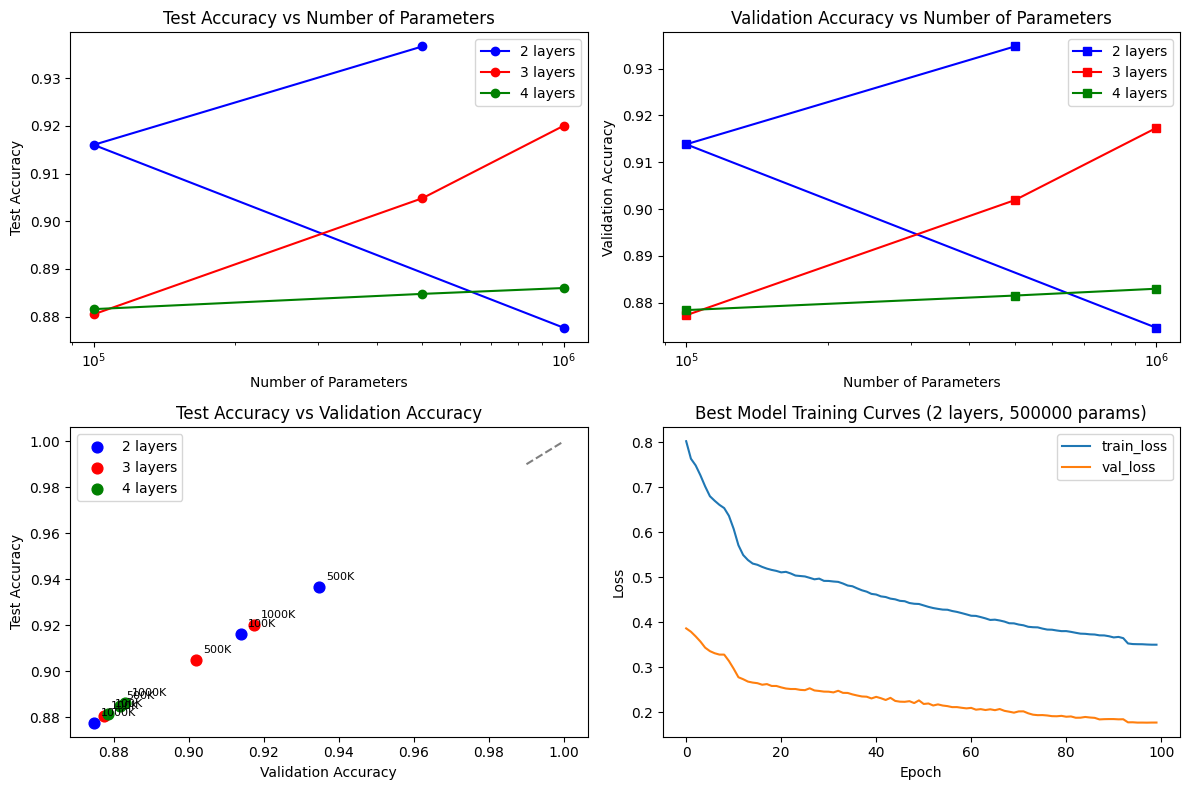

In [ ]:
# Load validation and test set ground truth labels
val_data = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_val.pkl'))
test_data = pd.read_pickle(os.path.join(PATH_DATA0, 'graphs','max_prob_10_subsample_0.1','graphs_test.pkl'))
val_y = torch.cat([graph.y for graph in val_data]).numpy()
test_y = torch.cat([graph.y for graph in test_data]).numpy()

# Collect all results
results = {}
for pkl_file in glob(os.path.join(PATH_DATA, 'euclidnet_*.pkl')):
    result = joblib.load(pkl_file)
    preds_test = (result['preds_test'] >= 0.5)
    preds_val = (result['preds_val'] >= 0.5)

    filename = os.path.basename(pkl_file).replace('.pkl', '')
    results[filename] = {
        'test_accuracy': (preds_test == test_y).astype(float).mean(),
        'val_accuracy': (preds_val == val_y).astype(float).mean()
    }

# Convert to DataFrame and sort
results_df = pd.DataFrame(results).T.sort_values('val_accuracy', ascending=False)

# Parse filenames into multi-level index
index_tuples = []
for filename in results_df.index:
    parts = filename.split('_')
    n_layers = parts[1]
    n_params = parts[2]
    index_tuples.append((n_layers, n_params))

results_df.index = pd.MultiIndex.from_tuples(index_tuples, names=['#layers', '#params'])

# Save results
results_df.to_csv(os.path.join(PATH_DATA, 'euclidnet_results.csv'))

# print("EuclidNet Results Summary:")
print("EuclidNet with Virtual Node Results Summary:")

print(results_df)

# Print best results
best_result = results_df.iloc[0]
print(f"\nBest model test accuracy: {best_result['test_accuracy']:.6f}")
print(f"Best model validation accuracy: {best_result['val_accuracy']:.6f}")

# Plot results visualization
plt.figure(figsize=(12, 8))

# Plot grouped by number of layers
layers = results_df.index.get_level_values(0).unique()
colors = ['blue', 'red', 'green', 'orange']

for i, layer in enumerate(layers):
    layer_data = results_df.loc[layer]
    params = [int(p) for p in layer_data.index]
    test_acc = layer_data['test_accuracy'].values
    val_acc = layer_data['val_accuracy'].values

    plt.subplot(2, 2, 1)
    plt.plot(params, test_acc, 'o-', color=colors[i], label=f'{layer} layers')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Test Accuracy')
    plt.title('Test Accuracy vs Number of Parameters')
    plt.legend()
    plt.xscale('log')

    plt.subplot(2, 2, 2)
    plt.plot(params, val_acc, 's-', color=colors[i], label=f'{layer} layers')
    plt.xlabel('Number of Parameters')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Number of Parameters')
    plt.legend()
    plt.xscale('log')

plt.subplot(2, 2, 3)
for i, layer in enumerate(layers):
    layer_data = results_df.loc[layer]
    params = [int(p) for p in layer_data.index]
    test_acc = layer_data['test_accuracy'].values
    val_acc = layer_data['val_accuracy'].values

    plt.scatter(val_acc, test_acc, color=colors[i], label=f'{layer} layers', s=60)

    # Add parameter count annotations
    for j, (v, t, p) in enumerate(zip(val_acc, test_acc, params)):
        plt.annotate(f'{p//1000}K', (v, t), xytext=(5, 5),
                    textcoords='offset points', fontsize=8)

plt.xlabel('Validation Accuracy')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Validation Accuracy')
plt.legend()
plt.plot([0.99, 1.0], [0.99, 1.0], 'k--', alpha=0.5)

plt.subplot(2, 2, 4)
# Show training curves for best configuration
best_config = results_df.index[0]
best_file = f"euclidnet_{best_config[0]}_{best_config[1]}.pkl"
best_result = joblib.load(os.path.join(PATH_DATA, best_file))
best_stats = pd.DataFrame(best_result['stats'])

best_stats[['train_loss', 'val_loss']].plot(ax=plt.gca())
plt.title(f'Best Model Training Curves ({best_config[0]} layers, {best_config[1]} params)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()